# Unscented Kalman Filter design for bicycle's kinematic motion model

In [1]:
# Import dependencies
from __future__ import division, print_function
%matplotlib inline

import scipy
from filterpy.kalman import unscented_transform, MerweScaledSigmaPoints

from UKF_RST import UnscentedKalmanFilter as UKF
from BicycleTrajectory2D import *
from BicycleUtils import *
from FormatUtils import *
from PlotUtils import *

## Simulation of kinematic motion model

In [2]:
[N, dt, wheel_distance] = [300, 0.05, 1.1]  # simulation parameters
add_noise = True  # Enable/disable gaussian noise

# Define initial state --------------------------------------------------------
delta = math.radians(6)  # steering angle
phi = math.radians(0)  # Lean angle
X_init = np.array([1.0, 3.0, 0.0, np.tan(delta)/wheel_distance, 0.0, phi]) # [x, y, z, sigma, psi, phi]

# Define constant inputs ------------------------------------------------------
U_init = np.array([1.0, 0.01, 0.01]) # [v, phi_dot, delta_dot]

# Define standard deviation for gaussian noise model --------------------------
# [xf, xr, yf, yr, zf, zr, za, delta, psi, phi]
if add_noise:
    noise = [0.5, 0.5, 0.5, 0.5, 0.1, 0.1, 0.1, 0.01, 0.01, 0.01]
else:
    noise = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
    
# Create object simulator ------------------------------------------------------
bike = BicycleTrajectory2D(X_init=X_init, U_init=U_init, noise=noise)

# Simulate path ----------------------------------------------------------------
(gt_sim, zs_sim, time) = bike.simulate_path(N=N, dt=dt)

## Implementation of UKF for $\sigma$-model

### Define state vector:

$$ X = 
\begin{bmatrix}x & y & z & v & \sigma & \psi & \phi \end{bmatrix}^\mathsf T$$

### Define measurement vector:

$$ Z = 
\begin{bmatrix}x_f & x_r & y_f & y_r & z_f & z_r & z_a & \sigma & \psi & \phi \end{bmatrix}^\mathsf T$$

In [3]:
class UKF_Sigma_model_sensor_fusion(object):
    def __init__(self, Q, R, sigma, dt=0.25, w=1.0):
        self.fx_filter_vel = 0.0
        self.fy_filter_vel = 0.0
        self.fz_filter_vel = 0.0
        self.fsigma_filter_vel = 0.0
        self.fpsi_filter_vel = 0.0
        self.fphi_filter_vel = 0.0
        self.U_init = []
                
        self.w = w
        self.dt = dt
        self.t = 0
        self.number_state_variables = 6
                         
        [self.alpha, self.beta, self.kappa] = [sigma[0], sigma[1], sigma[2]]
        
        self.points = MerweScaledSigmaPoints(n=self.number_state_variables, 
                                             alpha=self.alpha, beta=self.beta, kappa=self.kappa)

        self.kf = UKF(dim_x=number_state_variables, dim_z=10, dt=self.dt, 
                 fx=self.f_bicycle, hx=self.H_bicycle, points=self.points)
        
        # Q Process Noise Matrix
        self.kf.Q = Q 
       
        # R Measurement Noise Matrix
        self.kf.R = R

        self.kf.x = np.zeros((1, self.number_state_variables))    # Initial state
        self.kf.P = np.eye(self.number_state_variables) * 10     # Covariance matrix 

    def fx_filter(self, x, t):
        return self.fx_filter_vel

    def fy_filter(self, y, t):
        return self.fy_filter_vel
    
    def fz_filter(self, y, t):
        return self.fz_filter_vel
    
    def fsigma_filter(self, y, t):
        return self.fsigma_filter_vel

    def fpsi_filter(self, yaw, t):
        return self.fpsi_filter_vel
    
    def fphi_filter(self, yaw, t):
        return self.fphi_filter_vel
    
    def rk4(self, y, x, dx, f):
        k1 = dx * f(y, x)
        k2 = dx * f(y + 0.5*k1, x + 0.5*dx)
        k3 = dx * f(y + 0.5*k2, x + 0.5*dx)
        k4 = dx * f(y + k3, x + dx)

        return y + (k1 + 2*k2 + 2*k3 + k4) / 6.

    def f_bicycle(self, x, dt, U=None):  
        if U is None:
            U = self.U_init
            
        x_out = x
        [x_ini, y_ini, z_ini, sigma_ini, psi_ini, phi_ini] = x
        
        v_ini = U[0]
        phi_dot = U[1]
        delta_dot = U[2]

        #Solve diff equation by approximation
        x = self.rk4(x_ini, self.t, self.dt, self.fx_filter)
        y = self.rk4(y_ini, self.t, self.dt, self.fy_filter)
        z = self.rk4(z_ini, self.t, self.dt, self.fz_filter)
        sigma = self.rk4(sigma_ini, self.t, self.dt, self.fsigma_filter)
        psi = self.rk4(psi_ini, self.t, self.dt, self.fpsi_filter)
        phi = self.rk4(phi_ini, self.t, self.dt, self.fphi_filter)

        self.fx_filter_vel = math.cos(psi) * v_ini
        self.fy_filter_vel = math.sin(psi) * v_ini
        self.fz_filter_vel = 0
        self.fsigma_filter_vel = (phi_dot / self.w)*(1 + (self.w**2)*(sigma_ini**2))
        self.fpsi_filter_vel = (v_ini * sigma_ini) / math.cos(phi_ini)
        self.fphi_filter_vel = phi_dot

        x_out[0] = x
        x_out[1] = y
        x_out[2] = z
        x_out[3] = sigma
        x_out[4] = psi
        x_out[5] = phi

        return x_out

    def H_bicycle(self, x):
        """ takes a state variable and returns the measurement
        that would correspond to that state. """        
        sensor_out = np.zeros(10)
        sensor_out[0] = x[0]
        sensor_out[1] = x[0]
        sensor_out[2] = x[1]
        sensor_out[3] = x[1]
        sensor_out[4] = x[2]
        sensor_out[5] = x[2]
        sensor_out[6] = x[2]
        sensor_out[7] = x[3] # sigma
        sensor_out[8] = x[4] # psi
        sensor_out[9] = x[5] # phi
        
        return sensor_out

Execute UKF

In [4]:
np.random.seed(850)

file_name = "filters/UKF/math_model/"

[N, dt, wheel_distance, number_state_variables] = [300, 0.05, 1.1, 6]
delta = math.radians(6)
phi = math.radians(0)

U_init = np.array([1.0, 0.01, 0.01]) # [v, phi_dot, delta_dot]
X_init = np.array([1.0, 3.0, 0.0, np.tan(delta)/wheel_distance, 0.0, phi]) # [x, y, z, sigma, psi, phi]

# noise = [xf, xr, yf, yr, zf, zr, za, delta, psi, phi]
if add_noise:
    noise = [0.5, 0.5, 0.5, 0.5, 0.1, 0.1, 0.1, 0.01, 0.01, 0.01]
    file_name += "noise/"
else:
    noise = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
    file_name += "no_noise/"

bike = BicycleTrajectory2D(X_init=X_init, U_init=U_init, w=wheel_distance, noise=noise)

(gt_sim, zs_sim, time_t) = bike.simulate_path(N=N, dt=dt)

# Q Process Noise Matrix
Q = np.diag([(0.3)**2, (0.3)**2, (0.1)**2, (0.1)**2, (0.1)**2, (0.05)**2])  # [x, y, z, sigma, psi, phi]

# measurement noise covariance R [xf, xr, yf, yr, zf, zr, za, delta, psi, phi]
# R_std = [8.5**2, 8.5**2, 8.5**2, 1.8**2, 8.5**2, 1.8**2] # [x, y, z, sigma, psi, phi]
R_std = [8.5**2, 8.5**2,  # x
         8.5**2, 8.5**2,  # y
         7.5**2, 7.5**2, 7.5**2,  # z
         1.5**2, 1.5**2, 1.5**2] # delta - psi - phi

# R Measurement Noise Matrix
R = np.diag(R_std)

''' Sigma point'''
sigma = [alpha, beta, kappa] = [0.7, 2.0, -3.0]

filter_ukf = UKF_Sigma_model_sensor_fusion(Q=Q, R=R, sigma=sigma, dt=dt, w=wheel_distance)

Z  = np.zeros((1, 10))
xs = np.zeros((N, number_state_variables))
PU = np.zeros((N, number_state_variables))
KU = np.zeros((N, number_state_variables))

mus = np.zeros((N, number_state_variables))
us = np.zeros((N, 3))
dts = np.zeros((N, 1))  # real dt
ps = np.zeros((N, number_state_variables, number_state_variables))
qs = np.zeros((N, number_state_variables, number_state_variables))

for i in range(N):
    P = filter_ukf.kf.P
    K = filter_ukf.kf.K
    PU[i] = [P[0,0], P[1,1], P[2,2], P[3,3], P[4,4], P[5,5]]
    KU[i] = [K[0,0], K[1,1], K[2,2], K[3,3], K[4,4], K[5,5]]
    
    xs[i,:]  = filter_ukf.kf.x
    
    filter_ukf.kf.predict(fx_args=(U_init))
    
    Z[0, 0] = zs_sim[i].xf
    Z[0, 1] = zs_sim[i].xr
    Z[0, 2] = zs_sim[i].yf
    Z[0, 3] = zs_sim[i].yr
    Z[0, 4] = zs_sim[i].zf
    Z[0, 5] = zs_sim[i].zr
    Z[0, 6] = zs_sim[i].za
    Z[0, 7] = np.tan(zs_sim[i].delta)/wheel_distance  # sigma
    Z[0, 8] = zs_sim[i].psi # psi
    Z[0, 9] = zs_sim[i].phi # phi

    filter_ukf.kf.update(Z[0])
    
    cov = np.array([[P[0, 0], P[2, 0]], 
                    [P[0, 2], P[2, 2]]])
    mean = (xs[i, 0], xs[i, 1])
    
    # For later use with RTS smoother
    mus[i] = filter_ukf.kf.x
    ps[i] = filter_ukf.kf.P
    qs[i] = filter_ukf.kf.Q
    us[i] = U_init
    dts[i] = dt
    
xs[:, 3] = np.arctan2(xs[:, 3], 1/wheel_distance)  # sigma to delta conversion

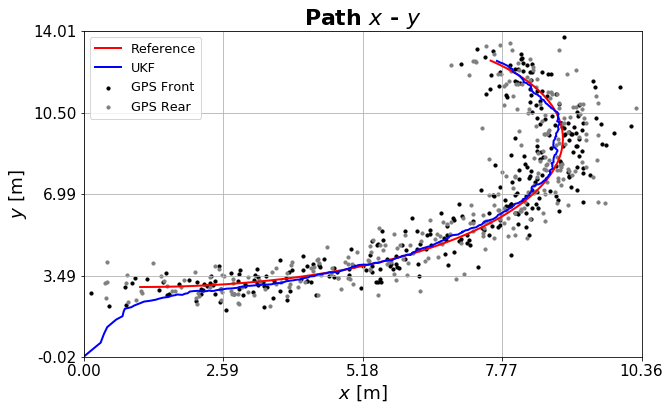

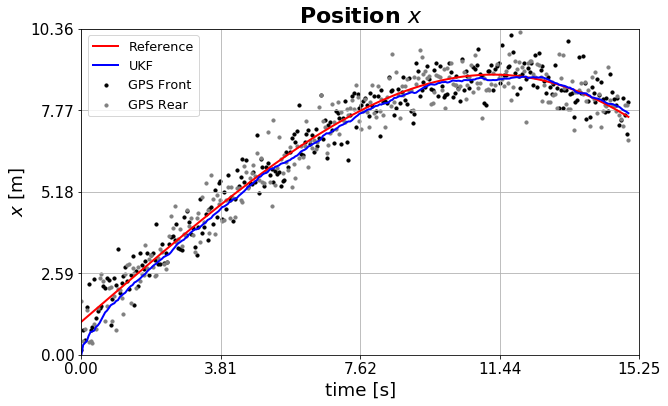

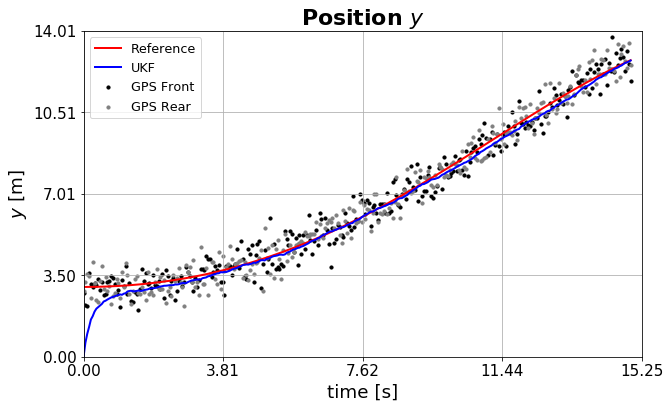

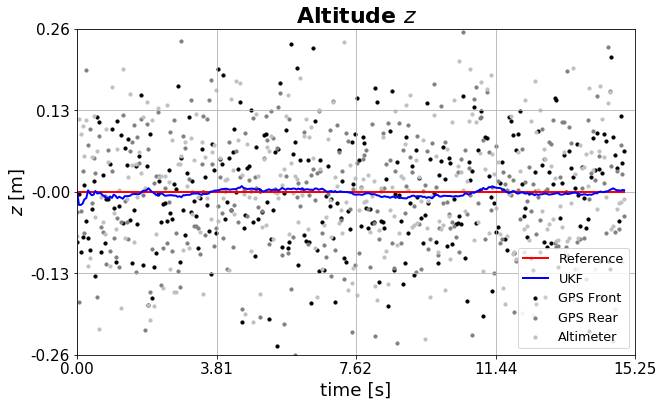

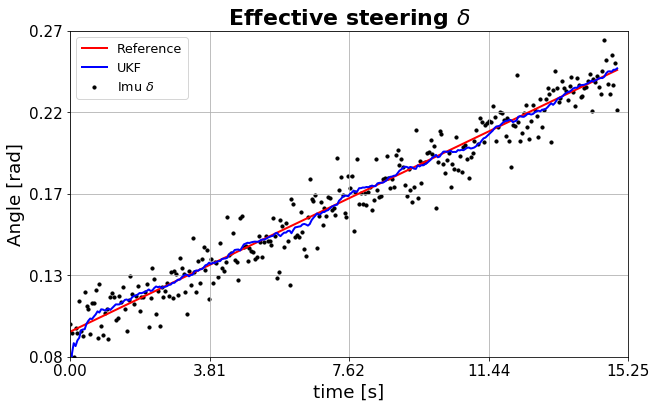

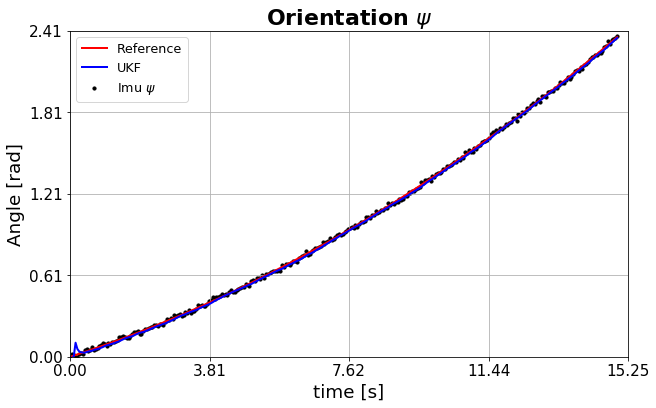

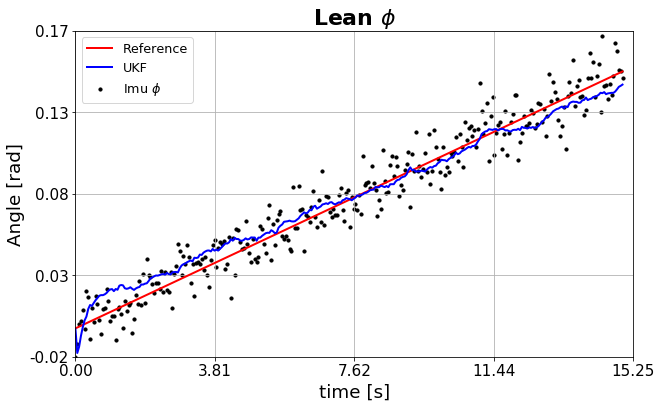

In [5]:
filter_name = 'UKF'
(gt, zs) = convert_object_to_array(gt_sim, zs_sim)
plot_filter_results(xs, gt, zs, time_t, file_name, filter_name)

Kalman gain and process covariance

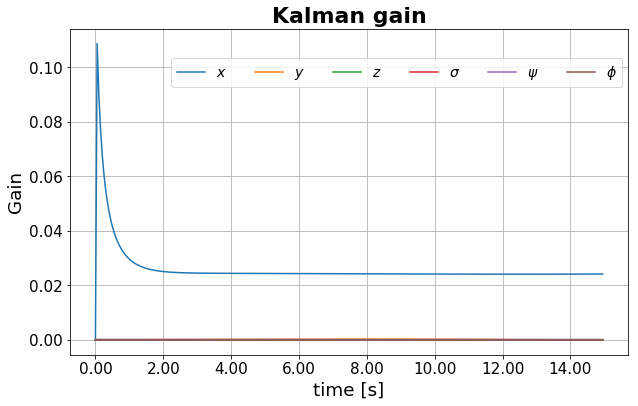

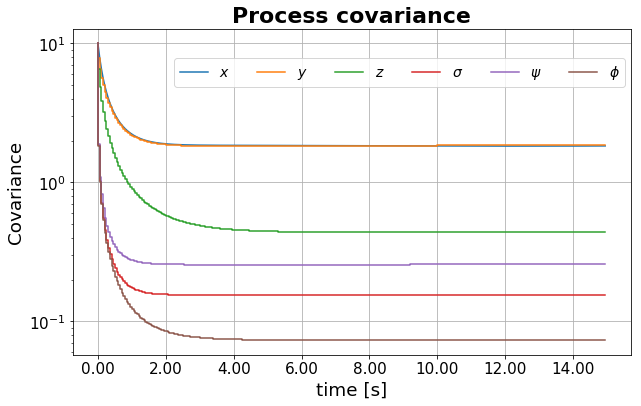

In [6]:
plot_EKF_gain_covariance(time, KU, PU, file_name, autoscale_axis=True)

## RTS Smoother

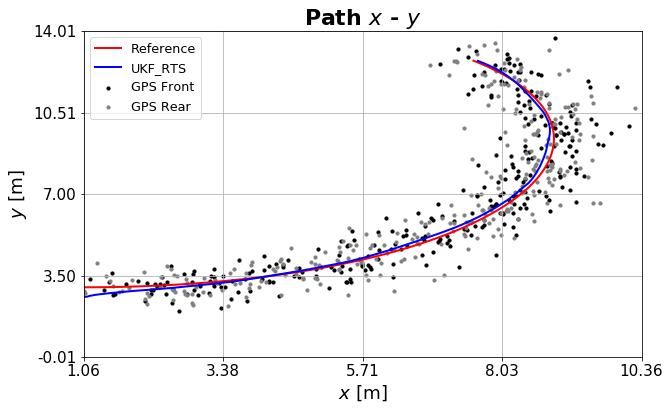

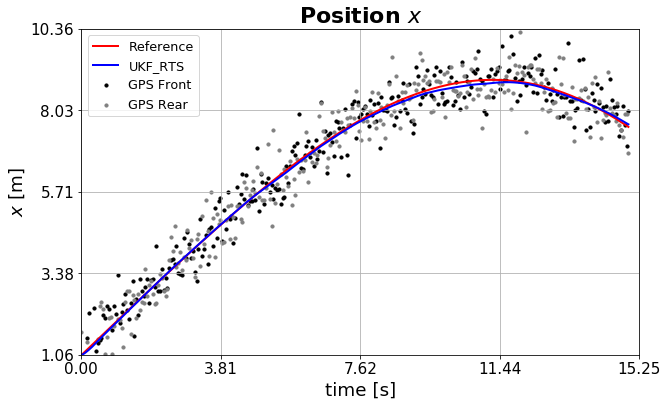

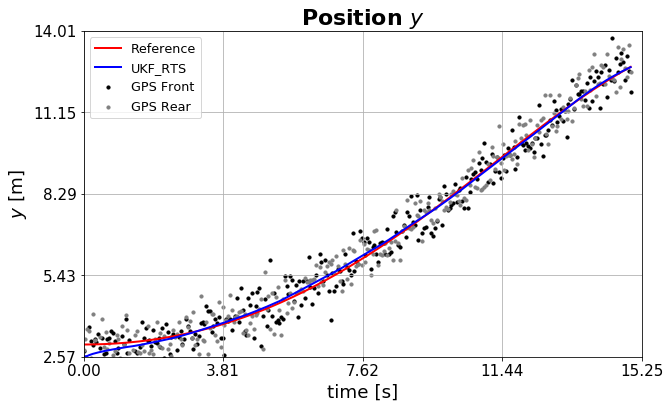

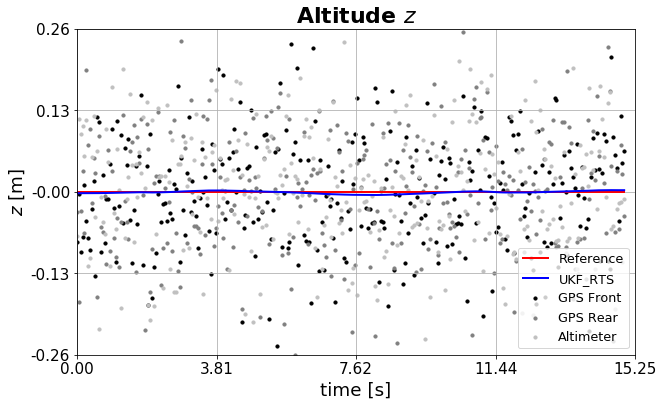

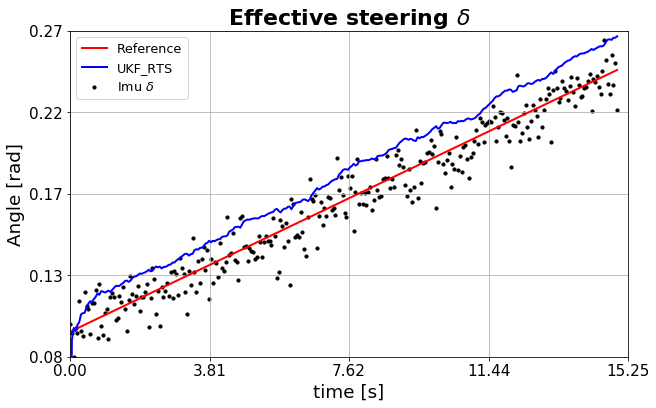

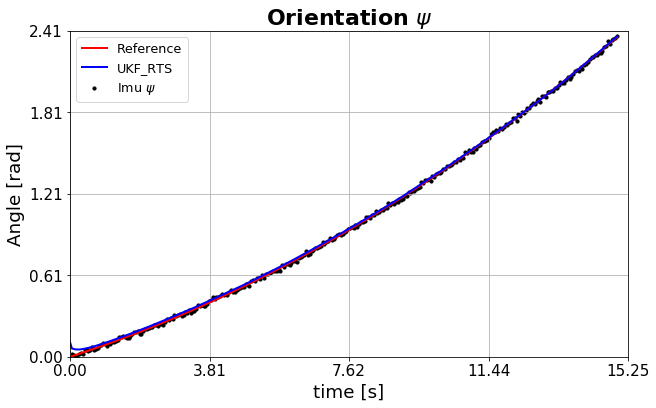

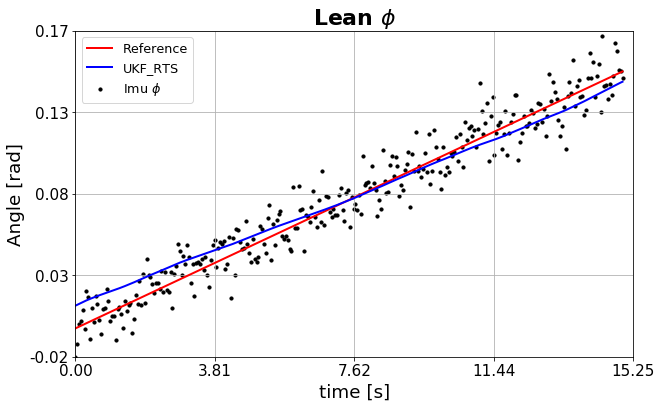

In [7]:
#filter_ukf.U_init = [0.0, 0.0, 0.0]# U_init
filter_ukf.U_init = U_init

(x, P, K) = filter_ukf.kf.rts_smoother(Xs=mus, Ps=ps, Qs=qs, dt=dts, U=us)
x[:, 3] = np.arctan2(xs[:, 3], 1/wheel_distance)  # sigma to delta conversion

gt_array = np.zeros((len(gt_sim), 6))
    
for i in range(len(gt_sim)):
    gt_array[i] = [gt_sim[i].x, gt_sim[i].y, gt_sim[i].z, gt_sim[i].delta, gt_sim[i].psi, gt_sim[i].phi]

filter_name = 'UKF_RTS'
rts_file_name = file_name + 'RTS_'
(gt, zs) = convert_object_to_array(gt_sim, zs_sim)
plot_filter_results(x, gt, zs, time_t, rts_file_name, filter_name)